# A quick stardate tutorial: measuring the ages of rotating stars

In this tutorial we'll infer the ages of some Kepler targets with measured rotation periods.

We'll start by downloading the McQuillan *et al.* (2014) (https://arxiv.org/abs/1402.5694) catalogue of stellar rotation periods.

In [1]:
import pandas as pd

url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)

In order to get some photometric colors for these stars (which is the minimum requirement to measure a *stardate* age), as well as some parallaxes, which will improve the age estimate, let's find these stars in the Gaia DR2 catalogue. Thankfully, we don't have to crossmatch targets ourselves because Megan Bedell has already done it for us (check out https://gaia-kepler.fun). Her table also contains useful information from the Kepler input catalogue. Let's download the Gaia-Kepler crossmatch.

In [2]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

Now let's merge these two data frames to make one data frame containing rotation periods, Gaia parallaxes, colours, etc.

In [28]:
df = pd.merge(mc, gaia, left_on="KID", right_on="kepid", how="inner")

Now we have everything we need (and more!) to start measuring ages. First, let's plot these stars on a (crude) colour-magnitude diagram and colour them by their rotation periods.

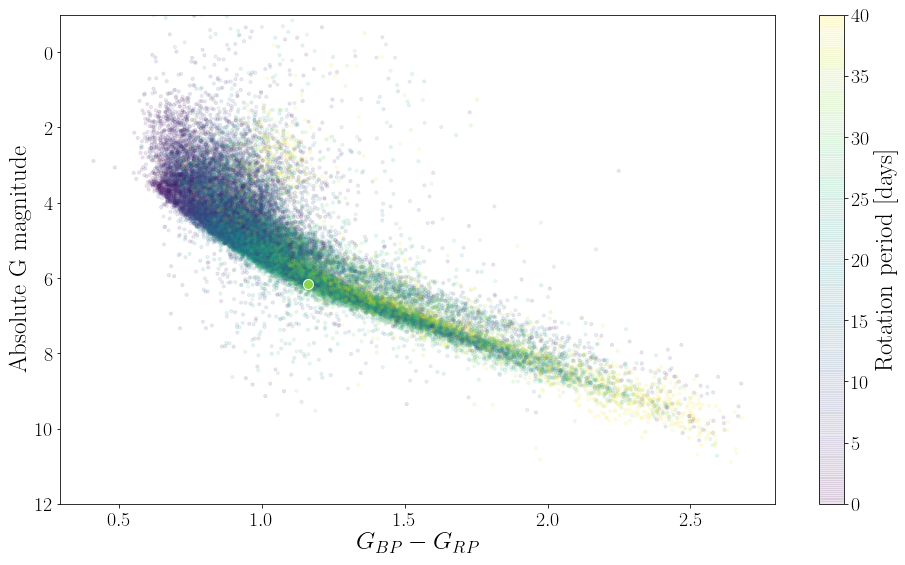

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plotpar = {'axes.labelsize': 25,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import numpy as np

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(abs(D)) + 5

abs_G = m_to_M(df.phot_g_mean_mag, (1./df.parallax)*1e3)

plt.figure(figsize=(16, 9))
plt.scatter(df.phot_bp_mean_mag - df.phot_rp_mean_mag, abs_G,
            c=df.Prot, s=10, alpha=.1, vmin=0, vmax=40);
plt.gca().invert_yaxis()
plt.ylim(12, -1)
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Absolute~G~magnitude}$");

np.random.seed(1234)
ind = np.random.randint(0, len(df))
plt.scatter([df.phot_bp_mean_mag[ind] - df.phot_rp_mean_mag[ind]], [abs_G[ind]], c=[df.Prot[ind]],
            s=100, vmin=0, vmax=40, edgecolor="w");

In this figure you can see that the lowest mass stars (bottom right) are rotating slowly and stars rotate more and more rapidly as they increase in mass. On the main sequence, stars of the same mass rotate more slowly as they get older and move up the y-axis. You can also see the binary sequence. On average, binary stars spin more rapidly than single stars. In this version of stardate we do not account for the possibility that a star might be in a binary.

# Inferring a stellar age

Now let's measure the age of a random star in this data set. We'll use the randomly chosen star plotted as a large circle on the CMD above.

We'll start by creating a dictionary of observables for this star. We'll use Gaia magnitudes *and* 2MASS JHK magnitudes (because they're available from the Kepler input catalogue) but one set of magnitudes would have worked too. These are the observables that provide information about the amount of hydrogen left in a star's core (i.e. placement on a stellar evolution track) which will be passed to the *isochrones* isochrone fitting algorithm. These observables could include photometric colours, atmospheric properties (effective temperature, surface gravity and metallicity), parallax, and even asteroseismic parameters. For most Kepler stars, only broad-band photometry is available so that's what we'll use here.

In [30]:
import stardate as sd

iso_params = {"G": (df.phot_g_mean_mag[ind], .05),  # We'll just estimate the uncertainties for now.
              "bp": (df.phot_bp_mean_mag[ind], .05),   
              "rp": (df.phot_rp_mean_mag[ind], .05),
              "J": (df.jmag[ind], .05),
              "H": (df.hmag[ind], .05),
              "K": (df.kmag[ind], .05),
              "parallax": (df.parallax[ind], df.parallax_error[ind])}  # Parallax in milliarcseconds.

This error message comes from the *isochrones* package and we're not going to use MultiNest so it's okay to ignore it! Pay attention to the exact format of the iso_params dictionary. The *isochrones* package requires it to be in exactly this format. Observables should be tuples containing values and uncertainties and this should **not be a pandas dictionary!** In addition, a new iso_params dictionary should be created for every star -- *isochrones* will not currently accept arrays of multiple stars). I'll walk you through running *stardate* on multiple stars later in this tutorial.

Now let's set up the star object. This is where we'll add the rotation period (Prot) and rotation period uncertainty (Prot_err).

In [31]:
# If you don't want to automatically save samples to disk (much faster):
star = sd.Star(iso_params, prot=df.Prot[ind], prot_err=df.Prot_err[ind])

# If you do want to save samples to disk (slower but assesses convergence,
# although this feature is still in beta), you can provide a directory and filename for the file location.
star = sd.Star(iso_params, prot=df.Prot[ind], prot_err=df.Prot_err[ind],
               savedir=".", filename="{}".format(df.KID[ind]));

If you want to save samples automatically, the savedir argument should be the path to the directory you'd like the posterior samples to be saved in. The default is the current working directory. The filename is the name you'd like to give to the h5 file that will contain the saved posterior samples. The default is "samples". It's useful to set this to the name or id of the star if you're running *stardate* on multiple stars.

If you want to run without saving samples, you can still save the samples later manually using h5py or similar.

If you know the v-band extinction you can pass that to the Star object too (I recommend using the [dustmaps](https://dustmaps.readthedocs.io/en/latest/) package to calculate this), e.g.:

In [32]:
star = sd.Star(iso_params, prot=df.Prot[ind], prot_err=df.Prot_err[ind], Av=.2, Av_err=.01,
               savedir=".", filename="{}".format(df.KID[ind]));

Now all we need to do is run the MCMC and wait.

In [40]:
nsteps = 10000
star.fit(max_n=nsteps)  # max_n is the number of MCMC steps to take.

100%|██████████| 10000/10000 [02:23<00:00, 69.50it/s]

nsteps 10000 burnin 0


If you want to save the samples automatically this becomes the following (but note this takes a lot more time for the same number of samples because of the I/O overhead):

In [41]:
star.fit(max_n=nsteps, save_samples=True)  # max_n is the number of MCMC steps to take but only 
                                           # 1/thin_by of these will be saved to file.
                                           # The default thin_by value is 100.

100%|██████████| 10000/10000 [02:24<00:00, 70.78it/s]

nsteps 100 burnin 0


# Accessing and plotting the results.

Let's print the median value of age and it's 16th and 84th percentile uncertainties.

In [42]:
median_age, age_errp, age_errm, age_samples = star.age_results()
print("Age = {0:.2f} + {1:.2f} - {2:.2f} Gyr".format(median_age, age_errp, age_errm))

Age = 3.95 + 0.26 - 3.41 Gyr


We can do the same thing for mass, metallicity, distance and extinction:

In [43]:
burnin = 10  # If you saved samples automatically, burnin is actually thin_by x larger than this.
             # If you didn't save samples, your probably want your burnin to be higher than this.

mass, mass_errp, mass_errm, mass_samples = star.mass_results(burnin=burnin)
print("Mass = {0:.2f} + {1:.2f} - {2:.2f} M_sun".format(mass, mass_errp, mass_errm))

feh, feh_errp, feh_errm, feh_samples = star.feh_results(burnin=burnin)
print("feh = {0:.2f} + {1:.2f} - {2:.2f}".format(feh, feh_errp, feh_errm))

lndistance, lndistance_errp, lndistance_errm, lndistance_samples = star.distance_results(burnin=burnin)
print("ln(distance) = {0:.2f} + {1:.2f} - {2:.2f} ".format(lndistance, lndistance_errp, lndistance_errm))

Av, Av_errp, Av_errm, Av_samples = star.Av_results(burnin=burnin)
print("Av = {0:.2f} + {1:.2f} - {2:.2f}".format(Av, Av_errp, Av_errm))

# You can load the flattened samples with
samples = star.samples
print("Sample array shape = ", np.shape(samples))

Mass = 0.79 + 0.04 - 0.02 M_sun
feh = -0.12 + 0.08 - 0.11
ln(distance) = 6.21 + 0.01 - 0.01 
Av = 0.20 + 0.01 - 0.01
Sample array shape =  (5000, 5)


If you want to load samples from an H5 file that you automatically saved earlier, you can do the following.

In [44]:
from stardate import load_samples, read_samples

# Load the samples. 
flatsamples, _3Dsamples, posterior_samples, prior_samples = load_samples(
    "{}.h5".format(df.KID[ind]), burnin=0)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)

# Print the results as a pandas dataframe.
results

,EEP_med,EEP_errm,EEP_errp,EEP_std,EEP_ml,age_med_gyr,age_errm,age_errp,age_std,age_ml_gyr,...,distance_errm,distance_errp,distance_std_pc,distance_ml,Av_med,Av_errm,Av_errp,Av_std,Av_ml,index
0,325.547866,2.309022,16.276724,11.698376,324.626181,3.949533,0.258675,3.405857,2.645121,3.841701,...,5.208036,5.469237,5.400902,496.36566,0.199628,0.010283,0.010199,0.010339,0.200185,0


flatsamples is a 2D array of samples, useful for making corner plots. samples is a 3D array of samples, useful for plotting chains. Both flatsamples and samples have an extra dimension containing the log-probability.

results is a pandas dictionary containing best-fit stellar parameters. It has both the median and maximum-likelihood values. I recommend using maximum-likelihood (suffixed with 'ml') values for stars with Gaia G_BP - G_RP color < 1.3 and median values (suffixed with 'med') for everything else.

Age is in gyr and distance is in pc. EEP is dimensionless. feh and Av are in dex.

Now we'll plot a histogram of the marginalized posterior over stellar age.

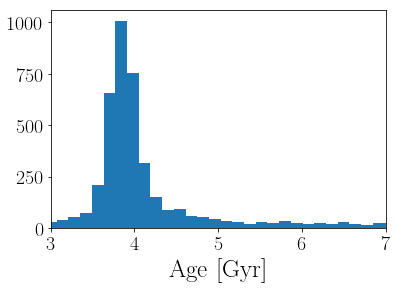

In [45]:
plt.hist((10**age_samples)*1e-9, 100);
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.xlim(3, 7);

And let's make a corner plot.

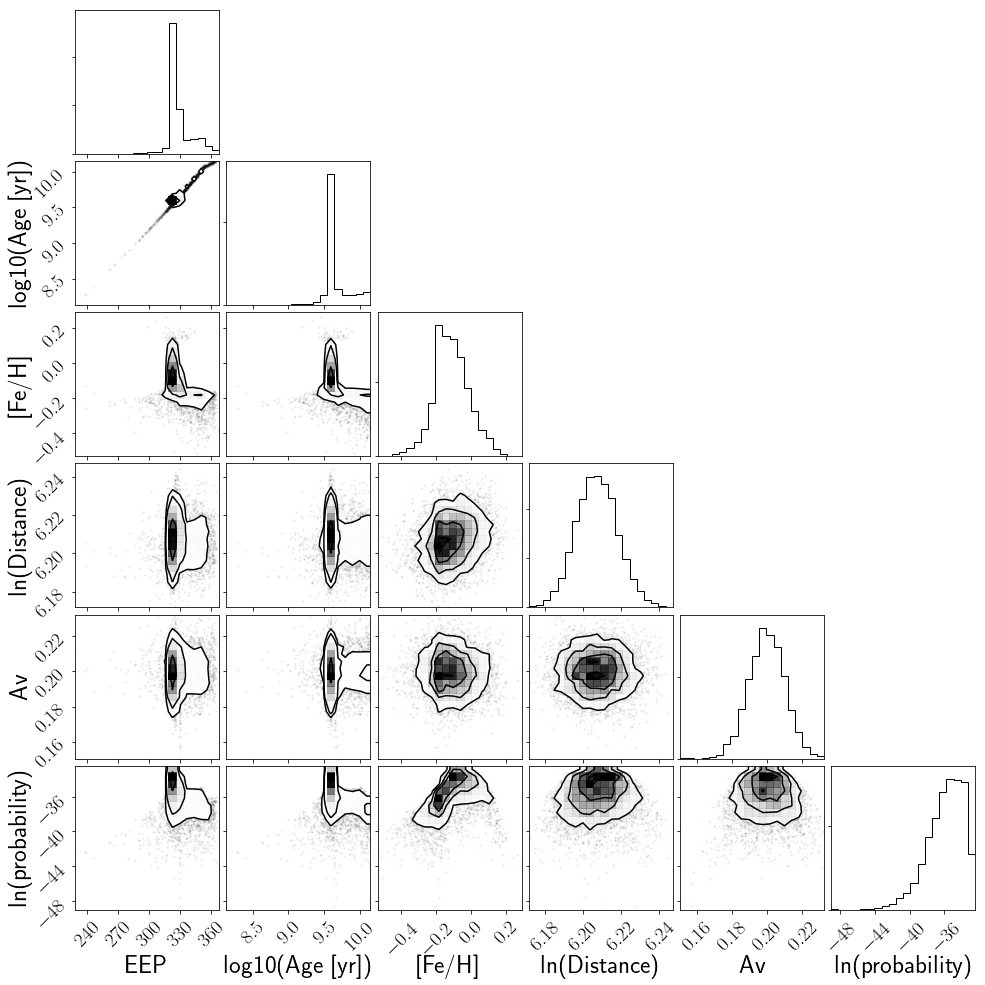

In [46]:
import corner

labels = ["EEP", "log10(Age [yr])", "[Fe/H]", "ln(Distance)", "Av", "ln(probability)"]

corner.corner(flatsamples, labels=labels);

# Multiple stars

Looping over multiple stars could look something like this:

In [18]:
N = 10  # Measure ages for the first 10 stars in the McQuillan catalog
ndim = 5  # There are 5 dimensions: EEP, age, feh, distance and Av
results = np.empty((N, ndim))  # An array to store summary statistics
ages, masses = [np.empty(N) for i in range(2)]
nsteps = 100   # You should set max_n much higher than this when you run for real.
nwalkers = 50  # stardate uses 50 walkers 
sample_array = np.zeros((nsteps*nwalkers, ndim, N))

for i in range(N):
    
    # You have to set up the parameter dictionary for every star.
    iso_params = {"G": (df.phot_g_mean_mag[i], .05),
                  "bp": (df.phot_bp_mean_mag[i], .004),    
                  "rp": (df.phot_rp_mean_mag[i], .004),
                  "J": (df.jmag[i], .05),
                  "H": (df.hmag[i], .05),
                  "K": (df.kmag[i], .05),
                  "parallax": (df.parallax[i], df.parallax_error[i])}  # Parallax in milliarcseconds.
    
    star = sd.Star(iso_params, df.Prot[i], df.Prot_err[i])  # , filename="{}".format(df.KID[i]));
    star.fit(max_n=nsteps)
    
    sample_array[:, :, i] = star.samples
    results[i, :] = np.median(star.samples, axis=0)
    
    # Or you could use the built-in functions to calculate medians.
    ages[i] = star.age_results()[0]
    masses[i] = star.mass_results()[0]

  7%|▋         | 7/100 [00:00<00:01, 67.40it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


 14%|█▍        | 14/100 [00:00<00:01, 66.27it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


 14%|█▍        | 14/100 [00:00<00:01, 67.04it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


 14%|█▍        | 14/100 [00:00<00:01, 64.71it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


  7%|▋         | 7/100 [00:00<00:01, 67.59it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


  7%|▋         | 7/100 [00:00<00:01, 69.26it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


 14%|█▍        | 14/100 [00:00<00:01, 65.61it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


  7%|▋         | 7/100 [00:00<00:01, 64.77it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


 14%|█▍        | 14/100 [00:00<00:01, 66.91it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


100%|██████████| 100/100 [00:02<00:00, 45.75it/s]

nsteps 100 burnin 0
(5000, 5) (5000, 5, 10)


In [19]:
print("Ages = ", results[:, 1], "\n")  # These ages are in log10(yrs)

print("Equivalent Evolutionary Points = ", results[:, 0], "\n")

print("Metallicities = ", results[:, 2], "\n")

print("Distances = ", results[:, 3], "\n")  # These are in ln(pc)

print("A_vs = ", results[:, 4], "\n")

Ages =  [9.51112504 9.90461703 9.56008607 9.55981386 9.73172604 9.62600584
 9.58434138 9.66127084 9.57374104 9.5595891 ] 

Equivalent Evolutionary Points =  [329.57897528 329.52641737 329.57626038 329.35732305 329.7935348
 329.3695938  329.57982176 329.57296482 330.14254528 329.57980668] 

Metallicities =  [-0.13635481 -0.20219718 -0.1029566  -0.0784935   0.04638792 -0.25294648
 -0.19802885 -0.19361006 -0.02608147 -0.04899971] 

Distances =  [5.56174874 5.71289638 5.572407   5.77557608 5.74169493 5.56985369
 5.71452286 5.61047538 5.71280237 5.56961465] 

A_vs =  [0.03380475 0.18007945 0.03253148 0.08023092 0.228755   0.09026418
 0.38374834 0.01566177 0.51577132 0.00850142] 



# Calculating other physical stellar parameters.

If you want to calculate a mass from a EEP, age and metallicity samples, you can do the following:

In [23]:
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

# Flatten sample array for the first star, computed above
flatsamples = np.reshape(sample_array[:, :, 0], (nsteps*nwalkers, ndim))

eep_samples = flatsamples[:, 0]
log_age_samples = flatsamples[:, 1]
feh_samples = flatsamples[:, 2]

mass_samps = mist.interp_value([eep_samples, log_age_samples, feh_samples], ["mass"])
print("mass = {0:.2f} M_sun".format(np.median(mass_samps)))

mass = 0.87 M_sun


You can use this same format to calculate other physical parameters too, e.g.:

In [24]:
radius_samps = mist.interp_value([eep_samples, log_age_samples, feh_samples], ["radius"])
print("radius = {0:.2f} R_sun".format(np.median(radius_samps)))

radius = 0.81 R_sun


In [25]:
teff_samps = mist.interp_value([eep_samples, log_age_samples, feh_samples], ["Teff"])
print("teff = {0:.0f} K".format(np.median(teff_samps)))

teff = 5485 K


In [26]:
logg_samps = mist.interp_value([eep_samples, log_age_samples, feh_samples], ["logg"])
print("logg = {0:.2f}".format(np.median(logg_samps)))

logg = 4.56


Take a look at the column headers of the MIST tables in the [isochrones](https://isochrones.readthedocs.io/en/latest/modelgrids.html) documentation for more physical parameters that are supported.

# Isochrone fitting only

It's also possible to switch off gyrochronology and just infer an age using isochrones only. This is useful if you'd like to predict ages for a list of stars where only some of them have rotation periods, or if you'd like to compare between gyro on and gyro off. There are a couple of different ways to do this. The simplest way is just to pass 'None' instead of a period and period uncertainty:

In [20]:
star = sd.Star(iso_params, prot=None, prot_err=None)

Passing zeros instead of Nones, or nothing at all will also work. You can also set the 'isochrone fitting only' key word argument to be true when you run the MCMC:

In [27]:
star.fit(max_n=1000, iso_only=True)

100%|██████████| 1000/1000 [00:06<00:00, 160.22it/s]

nsteps 1000 burnin 0


# Incorporating asteroseismology

As well as apparant magnitudes, parallax and spectroscopic parameters, you can also provide asteroseismic parameters in the dictionary of observables. The dictionary below is the full set of parameters that can be provided. These parameters do not all need to be provided and can be given in any order. The precision and accurancy of inferred ages will improve as more information is provided. See the [*isochrones* documentation](https://isochrones.readthedocs.io/en/latest/api.html#starmodel) for more information.

In [ ]:
iso_params = {"G": (G, G_err),  # Gaia magnitudes
              "bp": (G_bp, G_bp_err),    
              "rp": (G_rp, G_rp_err),
              "B": (B, B_err),  
              "V": (V, V_err),
              "J": (J, J_err),
              "H": (H, H_err),
              "K": (K, K_err),
              "g": (g, g_err),  # SDSS colours -- these are lower case.
              "r": (r, r_err),
              "i": (i, i_err),
              "z": (z, z_err),
              "teff": (teff, teff_err),  # Spectroscopic properties
              "logg": (logg, logg_err),
              "feh": (feh, feh_err),
              "nu_max": (nu_max, nu_max_err),  # Asteroseismic parameters
              "delta_nu": (delta_nu, delta_nu_err),  # Asteroseismic parameters
              "parallax": (parallax, parallax_error)}  # Parallax in milliarcseconds